### Data Loading

In [4]:
# NOTE: !!! THIS CELL SHOULD BE RUN FIRST !!!

# Jupyter notebooks have a bad interaction with virtual environments: 
# they perceive the PYTHONPATH as the folder the venv was activated
# instead of whatever the current directory of the .ipynb file is
# so we need to incorporate this hack

import sys

filepath = "/Users/colinyao/Desktop/Code/FINM/Portfolio_36700/HW/PortfolioRiskHW/HW3"
# change this path to whatever the path to this file is on your computer
sys.path.append(filepath)

import os
os.chdir(filepath)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load data
data = pd.read_excel('data/barnstable_analysis_data.xlsx', sheet_name='data', index_col=0)
data.index = pd.to_datetime(data.index)
data.index.name = 'date'

END_YR = 2024

# Split periods
data_1965_1999 = data[(data.index >= '1965-01-01') & (data.index <= '1999-12-31')]
data_2000_end = data[(data.index >= '2000-01-01') & (data.index <= f'{END_YR}-12-31')]
data_1926_end = data[(data.index >= '1926-01-01') & (data.index <= f'{END_YR}-12-31')]

# view data
data.head()

,SPX,TB1M
date,,
1926-01-30,-0.001783,0.003061
1926-02-27,-0.033297,0.002612
1926-03-31,-0.057708,0.002601
1926-04-30,0.038522,0.002270
1926-05-28,0.013623,0.002691


### 1. Summary Statistics (Annualized)

In [8]:
def annual_stats(df, rf_col='TB1M', rm_col='SPX'):
    df = df.copy()
    df['log_rm'] = np.log1p(df[rm_col])
    df['log_rf'] = np.log1p(df[rf_col])
    df['excess'] = df[rm_col] - df[rf_col]
    df['log_excess'] = df['log_rm'] - df['log_rf']
    
    ann_factor = 12
    stats = {
        'r^m mean': df[rm_col].mean()*ann_factor,
        'r^m vol': df[rm_col].std()*np.sqrt(ann_factor),
        'r^f mean': df[rf_col].mean()*ann_factor,
        'r^f vol': df[rf_col].std()*np.sqrt(ann_factor),
        'log r^m mean': df['log_rm'].mean()*ann_factor,
        'log r^m vol': df['log_rm'].std()*np.sqrt(ann_factor),
        'log r^f mean': df['log_rf'].mean()*ann_factor,
        'log r^f vol': df['log_rf'].std()*np.sqrt(ann_factor),
    }
    return pd.Series(stats)

tbl = pd.concat([
    annual_stats(data_1965_1999),
    annual_stats(data_2000_end),
    annual_stats(data_1926_end)
], axis=1)
tbl.columns = ['1965–1999', f'2000–{END_YR}', f'1926–{END_YR}']

print("Annualized Summary Statistics")
display(np.round(tbl, 4))

Annualized Summary Statistics


,1965–1999,2000–2024,1926–2024
r^m mean,0.1294,0.0875,0.1155
r^m vol,0.1494,0.1528,0.1866
r^f mean,0.0615,0.0175,0.0319
r^f vol,0.0072,0.0056,0.0085
log r^m mean,0.1176,0.0756,0.0978
log r^m vol,0.1496,0.1538,0.1859
log r^f mean,0.0613,0.0174,0.0318
log r^f vol,0.0071,0.0055,0.0085


# 2.1 Commentary
The full-sample mean lies between the two sub-sample means, which is to be expected. The full-sample volatility is higher in both cases than the sub-sample volatility, which implies that the mean is shifting over time (in agreement with positive mean over the time period). 

The level stats are similar in magnitude and have the same ordering as the log stats. This is not particularly surprising as the statistics are in a range where log(x) is approximately x, and log is a monotonic function. 

### 2.1 Calculate the probability of underperformance using the subsample 1965–1999.

In [9]:
def prob_underperformance(df):
    log_excess = np.log1p(df['SPX']) - np.log1p(df['TB1M']) # log excess returns of market over risk-free rate
    SR = log_excess.mean() / log_excess.std()
    h = np.arange(1, 31) # I choose a horizon of 1 to 30 years
    p = norm.cdf(-SR * np.sqrt(h)) # formula: P(underperformance) = Φ(-SR * √h)
    return pd.DataFrame({'Horizon (years)': h, 'Probability': p}), SR

prob_df, SR_6599 = prob_underperformance(data_1965_1999)
print(f"Sample Sharpe Ratio (log returns, 1965–1999): {SR_6599:.3f}")
display(prob_df.head(10)) # display first 10 rows, notice that the probability decreases with horizon

Sample Sharpe Ratio (log returns, 1965–1999): 0.110


,Horizon (years),Probability
0,1,0.456391
1,2,0.438450
2,3,0.424767
3,4,0.413301
4,5,0.403260
5,6,0.394237
6,7,0.385988
7,8,0.378357
8,9,0.371232
9,10,0.364534


### 2.2 Report the precise probability for (h = 15) and (h = 30) years

In [10]:
h15, h30 = 15, 30
p15 = norm.cdf(-SR_6599 * np.sqrt(h15))
p30 = norm.cdf(-SR_6599 * np.sqrt(h30))

print(f"Probability (h=15): {p15:.4%}")
print(f"Probability (h=30): {p30:.4%}")

Probability (h=15): 33.5707%
Probability (h=30): 27.4279%


### 2.3 Plot the probability as a function of the investment horizon, (h), for (0 < h \le 30) years.

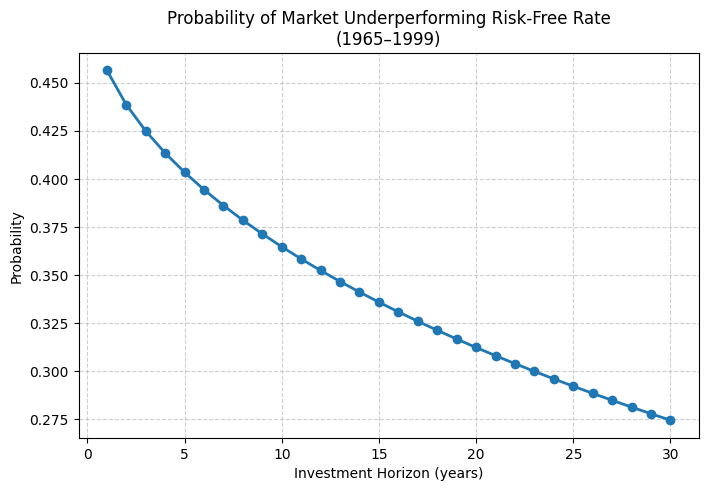

In [11]:
plt.figure(figsize=(8,5))
plt.plot(prob_df['Horizon (years)'], prob_df['Probability'], marker='o', lw=2)
plt.title('Probability of Market Underperforming Risk-Free Rate\n(1965–1999)')
plt.xlabel('Investment Horizon (years)')
plt.ylabel('Probability')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
# 3
data_1965_end = data[(data.index >= '1965-01-01') & (data.index <= f'{END_YR}-12-31')]
prob_65end_df, SR_65END = prob_underperformance(data_1965_end)
print(f"Sample Sharpe Ratio (log returns, 1965–END): {SR_65END:.3f}")
display(prob_65end_df.head(5), prob_65end_df.tail(5))

Sample Sharpe Ratio (log returns, 1965–END): 0.109


,Horizon (years),Probability
0,1,0.456461
1,2,0.438550
2,3,0.424888
3,4,0.413440
4,5,0.403414


,Horizon (years),Probability
25,26,0.288562
26,27,0.284945
27,28,0.281416
28,29,0.277970
29,30,0.274604


30 year probability 0.2746036886503085


In [25]:
data_2000_end

,SPX,TB1M
date,,
2000-01-31,-0.049630,0.004488
2000-02-29,-0.017458,0.004429
2000-03-31,0.098488,0.004880
2000-04-28,-0.031583,0.004392
2000-05-31,-0.022304,0.003896
...,...,...
2024-08-30,0.024283,0.004380
2024-09-30,0.022821,0.003826
2024-10-31,-0.008690,0.003752


In [33]:
# 4
x_mean_ins = tbl['1965–1999']['r^m mean']
sigma_vol_ins = tbl['1965–1999']['r^m vol']

year_prob_tuples = []
for year in range(2000, END_YR):
    cumulative_slice = data_2000_end[data_2000_end.index < str(year + 1) + '-01-01']['SPX']
    x_mean_oos = cumulative_slice.mean() * 12

    year_prob_tuples.append((year, norm.cdf(np.sqrt(year - 1999) * (x_mean_oos - x_mean_ins) / sigma_vol_ins)))

results = pd.DataFrame({"probability": [y[1] for y in year_prob_tuples]}, index=[y[0] for y in year_prob_tuples])
display(results)


,probability
2000,0.085454
2001,0.018271
2002,0.001068
2003,0.013221
2004,0.020068
2005,0.018752
2006,0.030138
2007,0.027328
2008,0.001163
2009,0.004482
